In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import plot_roc_curve, classification_report, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from preprocessing import sum_java_words, concat_loc_sum

### Rebuilding Random Forest on MSR data

In [3]:
msr_data = pd.read_csv('data/msr_dataset.csv', encoding = 'ANSI')
y_msr = msr_data['class']
msr = msr_data.drop(columns=['class'])

Training the model on MSR data and evaluating on 20% of the same dataset.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(msr, y_msr, train_size=0.8, 
                                                    random_state=33, shuffle=True)

msr_vectorizer = CountVectorizer(max_features=1000)
bow_train = msr_vectorizer.fit_transform(X_train['token'])
sparse_matrix_train = pd.DataFrame(bow_train.toarray(), columns = msr_vectorizer.get_feature_names())
X_train_count = concat_loc_sum(sparse_matrix_train, X_train)

bow_test = msr_vectorizer.transform(X_test['token'])
sparse_matrix_test = pd.DataFrame(bow_test.toarray(), columns = msr_vectorizer.get_feature_names())
X_test_count = concat_loc_sum(sparse_matrix_test, X_test)

msr_model = RandomForestClassifier()
msr_model.fit(X_train_count, y_train)
preds = msr_model.predict(X_test_count)

print(classification_report(y_test, preds))
print('f1', f1_score(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       283
           1       0.97      0.92      0.95       278

    accuracy                           0.95       561
   macro avg       0.95      0.95      0.95       561
weighted avg       0.95      0.95      0.95       561

f1 0.9463955637707949


0 means non-flaky and 1 means flaky.

Now the model is stored under the variable 'msr_model' and we ca use it on new data.

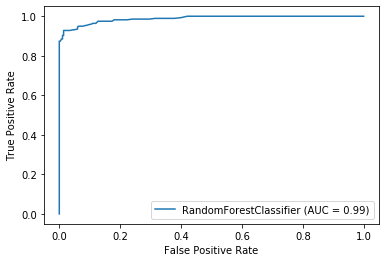

In [23]:
roc = plot_roc_curve(msr_model, X_test_count, y_test)

In [8]:
importances = pd.DataFrame(msr_model.feature_importances_, index = X_train_count.columns,
                            columns=['importance']).sort_values('importance', ascending=False)

importances[:50]

,importance
services,0.033411
action,0.028827
job,0.028799
table,0.026865
oozie,0.024313
loc,0.021066
cluster,0.019139
id,0.017854
coord,0.016416
getfilesystem,0.015143


Text(0, 0.5, 'Token')

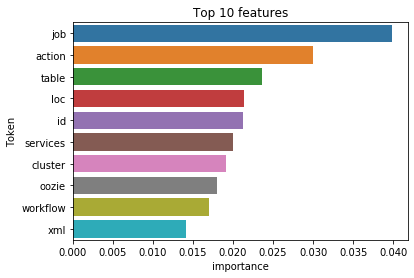

In [25]:
sns.barplot(y=importances.index[:10], x=importances['importance'][:10])
plt.title('Top 10 features')
plt.ylabel('Token')

### Evaluating MSR model on new data

In [26]:
new_data = pd.read_csv('data/new_dataset.csv')
y_new = new_data['class']
new = new_data.drop(columns=['class'])

In [27]:
X_new = msr_vectorizer.transform(new['token'])
sparse_matrix_new = pd.DataFrame(X_new.toarray(), columns = msr_vectorizer.get_feature_names())
X_new_count = concat_loc_sum(sparse_matrix_new, new_data)

new_preds = msr_model.predict(X_new_count)
print(classification_report(y_new, new_preds))
print('f1', f1_score(y_new, new_preds))

              precision    recall  f1-score   support

           0       0.51      0.98      0.67       724
           1       0.83      0.08      0.15       737

    accuracy                           0.53      1461
   macro avg       0.67      0.53      0.41      1461
weighted avg       0.67      0.53      0.41      1461

f1 0.14833127317676145


Seems like an overfitting scenario.